In [ ]:
#Import any library here only.
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import shutil
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import roc_auc_score
from keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:
''' Do not change this cell '''
#Functions

def check_gpu():
  if tf.test.gpu_device_name() != '':
    print("GPU sucessfully connected")
  else: print("PLease connect GPU")

def check_data():
  a = set()
  for image in Images:
    a.add(Image.shape[2])
  if len(a)==1 and len(Images)==624:
    print("PASS")
  else: print("FAIL")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <font color='orange'>Task #1</font>

Data loading and understanding data

Archive:  /content/drive/MyDrive/OpenCodeData.zip
replace OpenCodeData/OpenCodeData/INFECTED/person1_virus_11.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
''' Do not change this cell '''
check_gpu()

GPU sucessfully connected


In [ ]:
#Create two lists, images and labels. Store Input images in 'Images' list and its labels in 'Labels' list.
#Infected Images have two categories viral and bacterial. Find Number of images in each class. (Hint: See image name)
#Note that images are of different sizes.
images = []
labels = []
viral_ct=0
bacteria_ct=0
normal_ct=0
infected_ct=0
def process_images(dir,label):
  filename = os.listdir(dir)
  for img in tqdm(filename):
    path = os.path.join(dir,img)
    labels.append(label)
    image = cv2.imread(path)
    images.append(image)

def infected_category(dir):
  filename = os.listdir(dir)
  for img in tqdm(filename):
    path = os.path.join(dir,img)
    if 'virus' in img:
      labels.append("virus")
    elif 'bacteria' in img:
      labels.append("bacteria")
    else:
      labels.append("unidentified")
    image = cv2.imread(path)
    images.append(image)

process_images('/content/OpenCodeData/OpenCodeData/INFECTED',"infected")
process_images('/content/OpenCodeData/OpenCodeData/NORMAL',"normal")
infected_category('/content/OpenCodeData/OpenCodeData/INFECTED')
viral_ct+=labels.count("virus")
bacteria_ct+=labels.count("bacteria")
normal_ct+=labels.count("normal")
infected_ct+=labels.count("infected")

print(f"\n Viral Image Count: {viral_ct}")
print(f"\n Bacteria Image Count: {bacteria_ct}")
print(f"\n Normal Image Count: {normal_ct}")
print(f"\n Infected Image Count: {infected_ct}")



100%|██████████| 390/390 [00:06<00:00, 57.58it/s] 


 Viral Image Count: 148

 Bacteria Image Count: 242

 Normal Image Count: 234

 Infected Image Count: 390


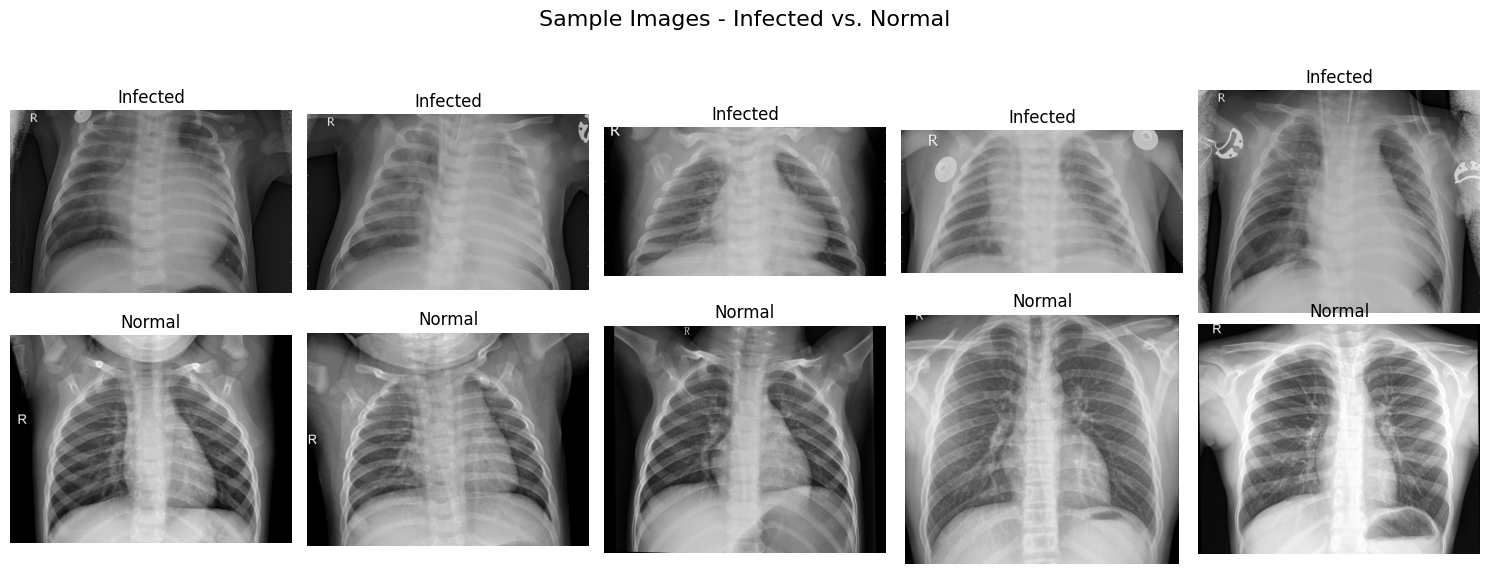

In [ ]:
infected_folder = '/content/OpenCodeData/OpenCodeData/INFECTED'
normal_folder = '/content/OpenCodeData/OpenCodeData/NORMAL/'

infected_images = [Image.open(os.path.join(infected_folder, img)).convert('RGB') for img in os.listdir(infected_folder)[:5]]
normal_images = [Image.open(os.path.join(normal_folder, img)).convert('RGB') for img in os.listdir(normal_folder)[:5]]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    axes[0, i].imshow(infected_images[i])
    axes[0, i].set_title("Infected")
    axes[0, i].axis('off')

    axes[1, i].imshow(normal_images[i])
    axes[1, i].set_title("Normal")
    axes[1, i].axis('off')
plt.suptitle('Sample Images - Infected vs. Normal', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
#Applied 4 types of image pre-processing techniques
def pre_processing(image):
    image = np.array(image) #converting image to a numpy array of pixels
    image = cv2.resize(image, (256,256))  # Resize the image
    image = image /255
    return image


In [ ]:
def plot_images(image_list, labels):
    plt.figure(figsize=(12, 6))
    for i in range(len(image_list)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(image_list[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
#Pre-processing all the images
infected_images = [Image.open(os.path.join(infected_folder, img)) for img in os.listdir(infected_folder)]
normal_images = [Image.open(os.path.join(normal_folder, img)) for img in os.listdir(normal_folder)]

In [ ]:
#For plotting purpose, doing 5 images.
infected_images_plot = [Image.open(os.path.join(infected_folder, img)) for img in os.listdir(infected_folder)[:5]]
normal_images_plot = [Image.open(os.path.join(normal_folder, img)) for img in os.listdir(normal_folder)[:5]]

In [ ]:
#All images pre-processed
pre_normal_images = [pre_processing(img) for img in normal_images]
pre_infected_images = [pre_processing(img) for img in infected_images]

#5 for plotting
pre_normal_images_plot = [pre_processing(img) for img in normal_images_plot]
pre_infected_images_plot = [pre_processing(img) for img in infected_images_plot]


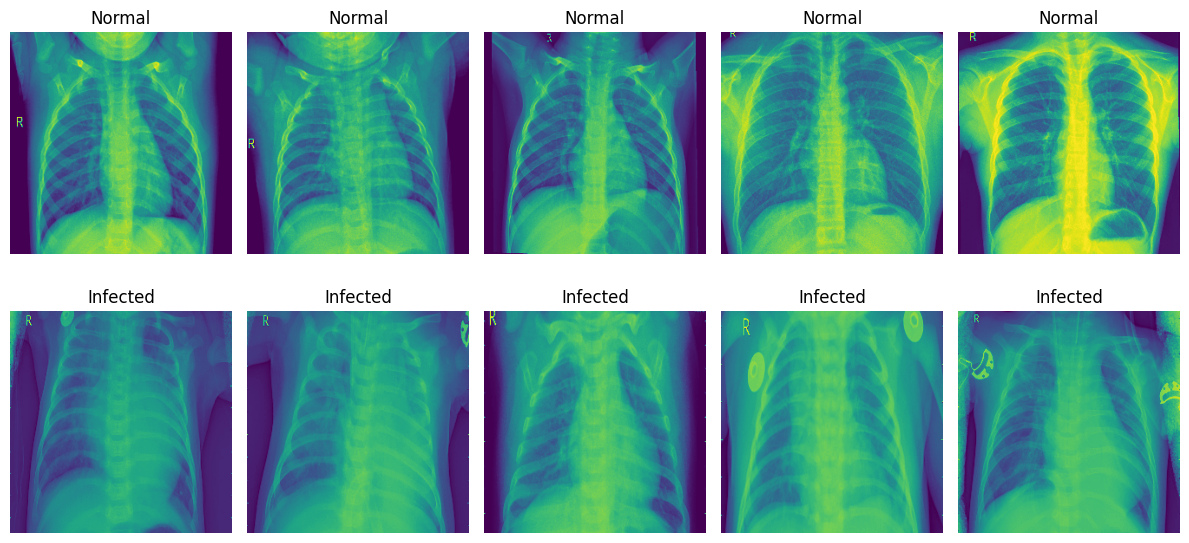

In [ ]:
plot_images(pre_normal_images_plot + pre_infected_images_plot, ['Normal'] * 5 + ['Infected'] * 5)

In [ ]:
#Splitting the Dataset into train, test and validation sets
normal_train, normal_test = train_test_split(pre_normal_images, test_size=0.15, random_state=42)
normal_train, normal_val = train_test_split(normal_train, test_size=0.17, random_state=42)  # 70% train, 15% val

In [ ]:
infected_train, infected_test = train_test_split(pre_infected_images, test_size=0.15, random_state=42)
infected_train, infected_val = train_test_split(infected_train, test_size=0.17, random_state=42)  # 70% train, 15% val

In [ ]:
#Analysing the splitted datasets
train_images = normal_train + infected_train
val_images = normal_val + infected_val
test_images = normal_test + infected_test

print(f"Train set size: {len(train_images)} images")
print(f"Validation set size: {len(val_images)} images")
print(f"Test set size: {len(test_images)} images")

Train set size: 438 images
Validation set size: 91 images
Test set size: 95 images


In [ ]:
# #Declaring parameters for augmentation
# datagen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

In [ ]:
# #Storing the images in their respective folders.
# for i,img in enumerate(train_images):
#     img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
#     imgs = Image.fromarray(img)
#     imgs= imgs.convert('RGB')
#     imgs.save(f"/content/drive/MyDrive/Train_data/image_{i}.jpeg")

# for i,img in enumerate(normal_train):
#     img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
#     imgs = Image.fromarray(img)
#     imgs= imgs.convert('RGB')
#     imgs.save(f"/content/drive/MyDrive/TrainData/Normal_Train/image_{i}.jpeg")

# for i,img in enumerate(infected_train):
#     img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
#     imgs = Image.fromarray(img)
#     imgs= imgs.convert('RGB')
#     imgs.save(f"/content/drive/MyDrive/TrainData/Infected_Train/image_{i}.jpeg")

# for i,img in enumerate(normal_test):
#     img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
#     imgs = Image.fromarray(img)
#     imgs= imgs.convert('RGB')
#     imgs.save(f"/content/drive/MyDrive/TestData/Normal_Test/image_{i}.jpeg")

# for i,img in enumerate(infected_test):
#     img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
#     imgs = Image.fromarray(img)
#     imgs= imgs.convert('RGB')
#     imgs.save(f"/content/drive/MyDrive/TestData/Infected_Test/image_{i}.jpeg")

# for i,img in enumerate(normal_val):
#     img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
#     imgs = Image.fromarray(img)
#     imgs= imgs.convert('RGB')
#     imgs.save(f"/content/drive/MyDrive/ValData/Normal_Val/image_{i}.jpeg")

# for i,img in enumerate(infected_val):
#     img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
#     imgs = Image.fromarray(img)
#     imgs= imgs.convert('RGB')
#     imgs.save(f"/content/drive/MyDrive/ValData/Infected_Val/image_{i}.jpeg")

In [ ]:
# dir ='/content/drive/MyDrive/Train_data'
# image_files = [os.path.join(dir, file) for file in os.listdir(dir)]
# final_images= image_files[:5]

# aug_images = []
# for path in final_images:

#     img = Image.open(path)
#     img_array = np.array(img)
#     img_array = img_array.reshape((1,) + img_array.shape)

#     aug = [datagen.flow(img_array).next()[0].astype(np.uint8)]
#     aug_images.extend(aug)

# plt.figure(figsize=(15, 5))
# for i, img in enumerate(aug_images[:5]):
#     plt.subplot(1, 5, i + 1)
#     plt.imshow(img)
#     plt.axis('off')
# plt.tight_layout()
# plt.show()
# #Plotting the augmented images, with zooming,flipping,shifting and rotating effects.

CNN to test MODEL


MODEL DESIGN


In [ ]:

train_dir = '/content/drive/MyDrive/TrainData'
val_dir = '/content/drive/MyDrive/ValData'
test_dir = '/content/drive/MyDrive/TestData'
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    shuffle = False
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
test_gen = val_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 438 images belonging to 2 classes.
Found 91 images belonging to 2 classes.
Found 95 images belonging to 2 classes.


MODEL BUILDING

In [ ]:
# Create a Sequential model
model = Sequential()

model.add(Conv2D(16, (3, 3), 1,activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3, 3),1, activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  #for other layers, activation relu, for final sigmoid, as for binary classification

# Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',AUC()])

# Model Summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 30, 30, 16)       

In [55]:
#Taining Model
history2 = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    epochs=15,
                    validation_data=val_gen,
                    validation_steps=len(val_gen)
)

Epoch 1/15
14/14 [==============================] - 2s 114ms/step - loss: 0.5132 - accuracy: 0.7808 - auc: 0.8266 - val_loss: 0.4095 - val_accuracy: 0.7802 - val_auc: 0.8911
Epoch 2/15
14/14 [==============================] - 2s 145ms/step - loss: 0.5723 - accuracy: 0.7717 - auc: 0.7662 - val_loss: 0.5707 - val_accuracy: 0.7033 - val_auc: 0.8978
Epoch 3/15
14/14 [==============================] - 3s 180ms/step - loss: 0.4560 - accuracy: 0.7854 - auc: 0.8595 - val_loss: 0.4272 - val_accuracy: 0.7802 - val_auc: 0.8893
Epoch 4/15
14/14 [==============================] - 4s 249ms/step - loss: 0.3180 - accuracy: 0.8790 - auc: 0.9385 - val_loss: 0.3656 - val_accuracy: 0.8571 - val_auc: 0.9020
Epoch 5/15
14/14 [==============================] - 3s 218ms/step - loss: 0.3069 - accuracy: 0.8813 - auc: 0.9400 - val_loss: 0.3977 - val_accuracy: 0.8571 - val_auc: 0.9020
Epoch 6/15
14/14 [==============================] - 3s 188ms/step - loss: 0.3193 - accuracy: 0.8584 - auc: 0.9510 - val_loss: 0.35

PLOTTING THE GRAPHS

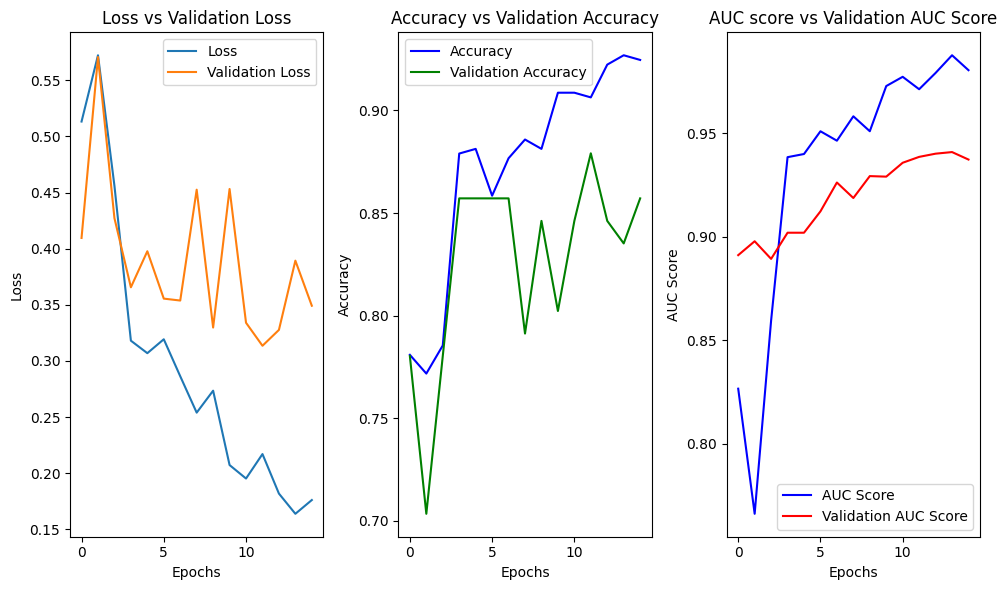

In [56]:
#Loss vs Validation loss
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(history2.history['accuracy'],'b', label='Accuracy')
plt.plot(history2.history['val_accuracy'],'g', label='Validation Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# AUC vs Validation AUC
plt.subplot(1, 3, 3)
plt.plot(history2.history['auc'], 'b', label='AUC Score')
plt.plot(history2.history['val_auc'], 'r', label='Validation AUC Score')
plt.title('AUC score vs Validation AUC Score')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()

plt.tight_layout()
plt.show()


ROC-AUC Score - 0.955

In [59]:
true_labels = test_gen.classes
predictions = model.predict(test_gen)
roc_auc = roc_auc_score(true_labels, predictions)
print(f"ROC-AUC Score on Validation Data: {roc_auc}")
#Since ROC-AUC score lies between 0 to 1, this is pretty good score indicating the effectiveness of the Model

3/3 [==============================] - 1s 157ms/step
ROC-AUC Score on Validation Data: 0.9792843691148776


TESTING MODEL


In [58]:

test_loss, test_accuracy,test_auc = model.evaluate(test_gen)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC Score: {test_auc}")


3/3 [==============================] - 0s 111ms/step - loss: 0.2091 - accuracy: 0.9158 - auc: 0.9793
Test Loss: 0.20907048881053925
Test Accuracy: 0.9157894849777222
Test AUC Score: 0.9792843461036682


CONFUSION MATRIX


3/3 [==============================] - 0s 120ms/step


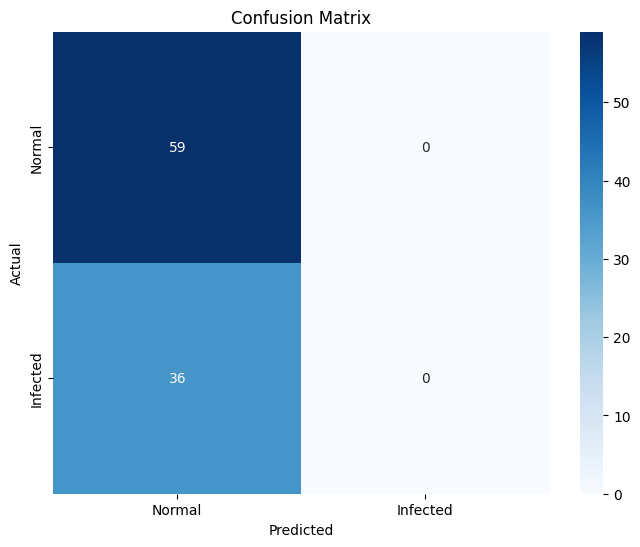

In [ ]:
predictions = model.predict(test_gen)
predicted_classes = (predictions > 0.5).astype('int32')

true_labels = test_gen.classes

conf_matrix = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Infected'],
            yticklabels=['Normal', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


SAVING MODEL

In [ ]:
model.save('CNN_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.applications.vgg16 import VGG16
pretrain = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(300,300,3)
)

In [ ]:
pretrain.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [ ]:
modelc= Sequential()

modelc.add(pretrain)
modelc.add( Flatten() )
modelc.add( Dense(128 , activation = 'relu'))
modelc.add( Dense(1,activation = 'sigmoid'))
modelc.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy','AUC']
  )

modelc.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 41472)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               5308544   
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 20023361 (76.38 MB)
Trainable params: 20023361 (76.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history3= modelc.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    epochs=15,
                    validation_data=val_gen,
                    validation_steps=len(val_gen)
)

Epoch 1/15
14/14 [==============================] - 67s 3s/step - loss: 0.8065 - accuracy: 0.5799 - auc: 0.4840 - val_loss: 0.6899 - val_accuracy: 0.4725 - val_auc: 0.8909
Epoch 2/15
14/14 [==============================] - 12s 820ms/step - loss: 0.6180 - accuracy: 0.6826 - auc: 0.6870 - val_loss: 0.4867 - val_accuracy: 0.8242 - val_auc: 0.9213
Epoch 3/15
14/14 [==============================] - 12s 836ms/step - loss: 0.5213 - accuracy: 0.7580 - auc: 0.8300 - val_loss: 0.4312 - val_accuracy: 0.8462 - val_auc: 0.9311
Epoch 4/15
14/14 [==============================] - 12s 872ms/step - loss: 0.4369 - accuracy: 0.8151 - auc: 0.8807 - val_loss: 0.3578 - val_accuracy: 0.8462 - val_auc: 0.9471
Epoch 5/15
14/14 [==============================] - 13s 894ms/step - loss: 0.3449 - accuracy: 0.8630 - auc: 0.9379 - val_loss: 0.3078 - val_accuracy: 0.8681 - val_auc: 0.9579
Epoch 6/15
14/14 [==============================] - 12s 857ms/step - loss: 0.2863 - accuracy: 0.8904 - auc: 0.9536 - val_loss: 0

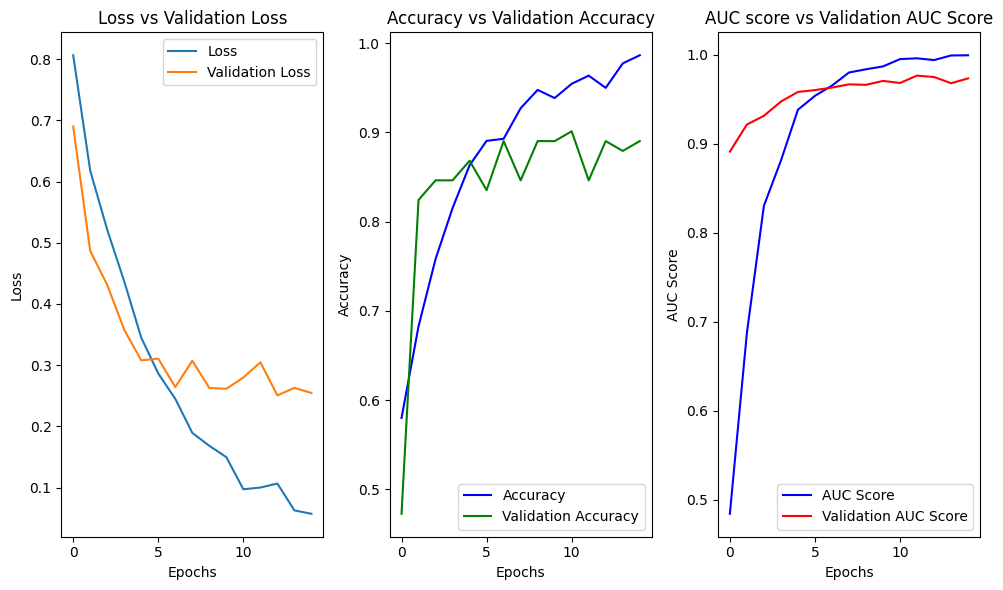

In [ ]:
#Loss vs Validation loss
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.plot(history3.history['loss'], label='Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(history3.history['accuracy'],'b', label='Accuracy')
plt.plot(history3.history['val_accuracy'],'g', label='Validation Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# AUC vs Validation AUC
plt.subplot(1, 3, 3)
plt.plot(history3.history['auc'], 'b', label='AUC Score')
plt.plot(history3.history['val_auc'], 'r', label='Validation AUC Score')
plt.title('AUC score vs Validation AUC Score')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
true_labels = val_gen.classes
predictions = modelc.predict(val_gen)
roc_auc = roc_auc_score(true_labels, predictions)
print(f"ROC-AUC Score on Validation Data: {roc_auc}")
#Since ROC-AUC score lies between 0 to 1, this is pretty good score indicating the effectiveness of the Model

3/3 [==============================] - 1s 261ms/step
ROC-AUC Score on Validation Data: 0.9731682146542827


3/3 [==============================] - 10s 5s/step


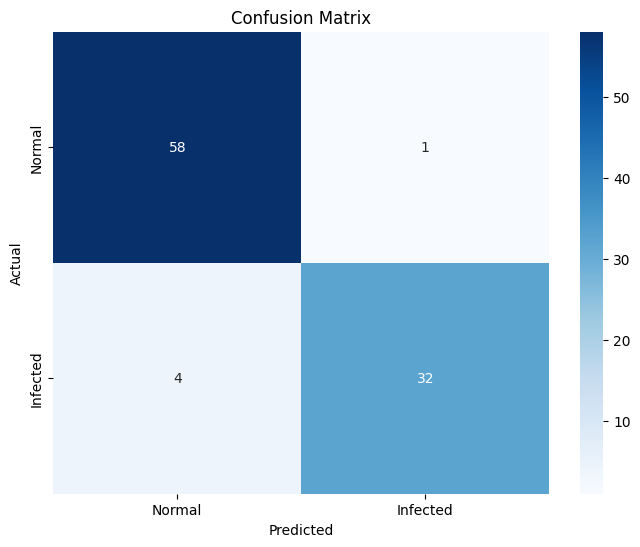

In [ ]:
predictions = modelc.predict(test_gen)
predicted_classes = (predictions > 0.5).astype('int32')

true_labels = test_gen.classes

conf_matrix = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Infected'],
            yticklabels=['Normal', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
modelc.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
